Подключаем стандартные библиотеки для работы с данными и визуализации данных

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt #для графики

Импортируем файлик с данными 

In [2]:
data = pd.read_csv('/Users/adeliabiganakova/Desktop/Cancer model/Cancer_Data.csv') 
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Корректируем данные: убираем значения 'id' 'Unnamed:32', потому что они не информативны и вносят шумы в обучение. Объекты преобразуем в числа, так как дальше мы будем нормализовать данные. Поскольку мы решаем задачу бинарной классификации, в значении diagnosis будет 1, если опухоль злокачественная (M == malignant), и 0, если доброкачественная (B)

In [3]:
data.drop(["Unnamed: 32","id"],axis=1,inplace = True) 
data.diagnosis = [1 if each == "M" else 0 for each in data.diagnosis] 
y = data.diagnosis.values
x_data = data.drop(["diagnosis"],axis = 1)
print(pd.DataFrame(x_data))
print(pd.DataFrame(y))

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean   
0          17.99         10.38          122.80     1001.0          0.11840  \
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     compactness_mean  concavity_mean  concave points_mean  sym

Нормируем данные 

In [4]:
x = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data)) #Normalization Formula
print(pd.DataFrame(x))

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean   
0       0.004229      0.002440        0.028867   0.235308         0.000028  \
1       0.004835      0.004177        0.031241   0.311707         0.000020   
2       0.004629      0.004995        0.030559   0.282793         0.000026   
3       0.002685      0.004791        0.018237   0.090762         0.000033   
4       0.004770      0.003371        0.031758   0.304890         0.000024   
..           ...           ...             ...        ...              ...   
564     0.005068      0.005263        0.033380   0.347673         0.000026   
565     0.004732      0.006641        0.030842   0.296427         0.000023   
566     0.003902      0.006601        0.025458   0.201716         0.000020   
567     0.004843      0.006895        0.032934   0.297367         0.000028   
568     0.001824      0.005769        0.011265   0.042548         0.000012   

     compactness_mean  concavity_mean  concave points_mean  sym

Делим все данные на тренировочные и тестирующие

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

Транспонируем матрицы для того, чтобы можно было их перемножать (ну из-за "nxm mxn")

In [6]:
x_train = x_train.T 
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

Определяем стандартные веса и байес

In [7]:
def initialize_weights_and_bias(dimension):
    w=np.full((dimension,1),0.01) 
    b = 0.0 
    
    return w,b

В качестве функции выбираем сигмоиду, потому что она точно в диапозоне от 0 до 1, и дифференциируема (можно использовать в градиентном спуске)

In [8]:
def sigmoid(z): 
    y_head = 1/(1+np.exp(-z)) 
    return y_head 

Дальше будут все функции, которые мы используем, но с описанием 

In [9]:
def forward_bacward_propagation(w,b,x_train,y_train):
    '''
    Функция "forward_backward_propagation" выполняет прямое и обратное распространение ошибки в нейросети. Входные параметры функции включают:

    Входные параметры:
    - w: начальные значения весов
    - b: начальные значения смещения
    - x_train: данные для тренировки нейросети (признаки)
    - y_train: данные для тренировки нейросети (целевые значения)

    Функция состоит из двух основных этапов:

    1. Прямое распространение (FORWARD):
    - Вычисление линейной комбинации входных данных и весов (z = np.dot(w.T, x_train) + b)
    - Применение функции активации (sigmoid) для получения предсказаний (y_head = sigmoid(z))
    - Вычисление функции потерь (loss) с использованием кросс-энтропии
    - Вычисление средней стоимости (cost) по всем обучающим примерам

    2. Обратное распространение (BACKWARD):
    - Вычисление производной функции стоимости по весам (derivative_weight)
    - Вычисление производной функции стоимости по сдвигу (derivative_bias)
    - Формирование словаря с градиентами (gradients)

    Функция возвращает два значения:

    - cost: средняя стоимость (ошибка) на обучающих данных
    - gradients: словарь с градиентами (производными) функции стоимости по весам и сдвигу

    Эта функция используется в процессе обучения нейросети для оптимизации весов и сдвига с целью минимизации ошибки на обучающих данных.
    '''

    #FORWARD
    z = np.dot(w.T,x_train)+b 
    y_head = sigmoid(z) 
    loss= -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head) 
    cost = (np.sum(loss))/x_train.shape[1] 

    #BACKWARD
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] 
    derivative_bias= np.sum(y_head-y_train)/x_train.shape[1] 
        
    gradients = {"derivative_weight": derivative_weight, "derivative_bias":derivative_bias} 
    return cost,gradients


def update(w, b, x_train, y_train, learning_rate, number_of_iteration):
    cost_list = []
    cost_list2 = []
    index =  []
    '''
    Функция 2update" выполняет обновление параметров весов (w) и смещения (b) на основе данных обучения (x_train, y_train), скорости обучения (learning_rate) и количества итераций (number_of_iteration). 
    В процессе обучения функция выполняет прямое и обратное распространение ошибки для вычисления градиентов и стоимости функции потерь. Затем параметры обновляются с использованием градиентного спуска.

    Входные параметры:
    - w: начальные значения весов
    - b: начальные значения смещения
    - x_train: обучающие данные
    - y_train: метки классов для обучающих данных
    - learning_rate: скорость обучения
    - number_of_iteration: количество итераций обучения

    Функция возвращает обновленные параметры, градиенты и список стоимостей функции потерь на каждой итерации. 
    В процессе обучения функция также выводит стоимость функции потерь после каждой 10-й итерации и отображает график изменения стоимости функции потерь в зависимости от количества итераций.
    
    '''
    cost_list = []
    cost_list2 = []
    index =  []
        
        
    #updating(Learning) parameters is number_of_iteration times
    for i in range(number_of_iteration):
    # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_bacward_propagation(w,b,x_train,y_train)
        cost_list.append(cost) 
    #lets update 
        
        w = w - learning_rate * gradients["derivative_weight"]   
        b = b - learning_rate * gradients["derivative_bias"]   
        if i % 10 == 0: 
            cost_list2.append(cost) 
            index.append(i)
            print("Cost after iteration %i: %f" %(i,cost)) 
                
        # we update(learn) parameters wights and bias
    parameters = {"weight": w, "bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation="vertical")
    plt.xlabel("Number of iteration")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    '''
    Функция "predict" выполняет прогнозирование значения на основе входных данных.

    Входные параметры:
    - w: начальные значения весов
    - b: начальные значения смещения
    - x_test: тестовые данные

    В начале функции выполняется прямое распространение, где входные данные умножаются на веса и добавляется смещение. Затем применяется функция активации сигмоида для получения значения z.
    Далее создается массив Y_prediction с нулевыми значениями, который будет хранить результаты прогнозирования. 
    В цикле функция проверяет значения z: если значение меньше или равно 0.5, то прогнозируемый результат равен 0, в противном случае - 1. 
    После завершения цикла функция возвращает массив Y_prediction с прогнозированными значениями.
    '''

    #x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1])) 
    #if z is bigger than 0.5 our prediction is sign one (y_head = 1)
    #if z is smaller than 0.5 our prediction is sign one (y_head = 0)
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5: 
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
                
    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    '''
    Функция logistic_regression выполняет логистическую регрессию на нейросети для заданных обучающих и тестовых данных. 

    Входные параметры функции:
    - x_train: данные для тренировки нейросети (признаки)
    - y_train: данные для тренировки нейросети (целевые значения)
    - x_test: данные для тестирования нейросети (признаки)
    - y_test: данные для тестирования нейросети (целевые значения)
    - learning_rate: скорость обучения
    - num_iterations: количество итераций обучения

    Функция выполняет следующие шаги:
    1. Инициализация весов и смещения с помощью функции initialize_weights_and_bias.
    2. Обновление параметров с помощью функции update, которая возвращает обновленные параметры, градиенты и список стоимостей.
    3. Предсказание меток классов для тестовых данных с использованием функции predict.
    4. Расчет и вывод точности тестовых данных.
    '''
    # initialize
    dimension =  x_train.shape[0]  # that is 30
    w,b = initialize_weights_and_bias(dimension)
    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
        
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)  #predict
    
    # Print train/test Errors
    
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

Cost after iteration 0: 0.692873
Cost after iteration 10: 0.638682
Cost after iteration 20: 0.614395
Cost after iteration 30: 0.592721
Cost after iteration 40: 0.573297
Cost after iteration 50: 0.555842
Cost after iteration 60: 0.540100
Cost after iteration 70: 0.525848
Cost after iteration 80: 0.512892
Cost after iteration 90: 0.501068
Cost after iteration 100: 0.490236
Cost after iteration 110: 0.480277
Cost after iteration 120: 0.471090
Cost after iteration 130: 0.462587
Cost after iteration 140: 0.454695
Cost after iteration 150: 0.447349
Cost after iteration 160: 0.440494
Cost after iteration 170: 0.434082
Cost after iteration 180: 0.428070
Cost after iteration 190: 0.422422
Cost after iteration 200: 0.417104
Cost after iteration 210: 0.412088
Cost after iteration 220: 0.407349
Cost after iteration 230: 0.402864
Cost after iteration 240: 0.398612
Cost after iteration 250: 0.394575
Cost after iteration 260: 0.390738
Cost after iteration 270: 0.387085
Cost after iteration 280: 0.383

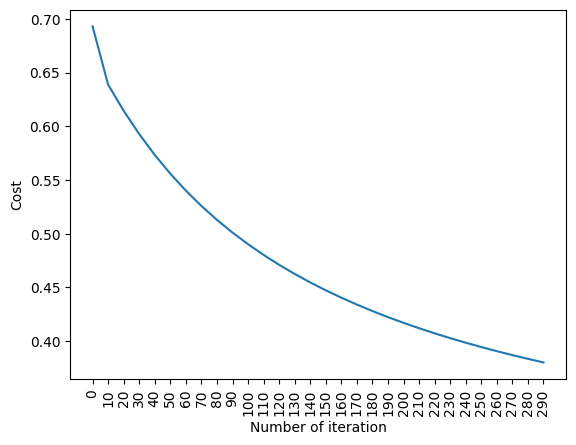

test accuracy: 90.35087719298245 %


In [10]:
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 1, num_iterations = 300)